In [1]:
from transformers import LayoutLMv3FeatureExtractor, LayoutLMv3TokenizerFast, LayoutLMv3Processor, LayoutLMv3ForSequenceClassification
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from sklearn.model_selection import train_test_split
import imgkit
import easyocr
import torchvision.transforms as T
from pathlib import Path
import matplotlib.pyplot as plt
import os
import cv2
from typing import List
import json
from torchmetrics import Accuracy
from huggingface_hub import notebook_login
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline
pl.seed_everything(42)

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 42


42

In [8]:
image_paths = sorted(list(Path("images").glob("*/*.jpg")))
train_images, test_images = train_test_split(image_paths, test_size=.2)


In [9]:
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

In [10]:
model = LayoutLMv3ForSequenceClassification.from_pretrained("humanai2025/layoutlmv3-fdc")
model = model.eval().to(DEVICE)

In [11]:
def predict_document_image(
    image_path: Path,
    model: LayoutLMv3ForSequenceClassification,
    processor: LayoutLMv3Processor):

    json_path = image_path.with_suffix(".json")
    with json_path.open("r") as f:
        ocr_result = json.load(f)

        with Image.open(image_path).convert("RGB") as image:

            width, height = image.size
            width_scale = 1000 / width
            height_scale = 1000 / height

            words = []
            boxes = []
            for row in ocr_result:
                boxes.append(
                    scale_bounding_box(
                        row["bounding_box"],
                        width_scale,
                        height_scale
                    )
                )
                words.append(row["word"])

            encoding = processor(
                image,
                words,
                boxes=boxes,
                max_length=512,
                padding="max_length",
                truncation=True,
                return_tensors="pt"
            )

    with torch.inference_mode():
        output = model(
            input_ids=encoding["input_ids"].to(DEVICE),
            attention_mask=encoding["attention_mask"].to(DEVICE),
            bbox=encoding["bbox"].to(DEVICE),
            pixel_values=encoding["pixel_values"].to(DEVICE)
        )

    predicted_class = output.logits.argmax()
    return model.config.id2label[predicted_class.item()]

In [14]:
feature_extractor = LayoutLMv3FeatureExtractor(apply_ocr=False)
tokenizer = LayoutLMv3TokenizerFast.from_pretrained("microsoft/layoutlmv3-base")
processor = LayoutLMv3Processor(feature_extractor, tokenizer)

/opt/conda/lib/python3.7/site-packages/transformers/models/layoutlmv3/feature_extraction_layoutlmv3.py:33: FutureWarning: The class LayoutLMv3FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv3ImageProcessor instead.
  FutureWarning,


In [16]:
def scale_bounding_box(box: List[int], width_scale : float = 1.0, height_scale : float = 1.0) -> List[int]:
    return [
        int(box[0] * width_scale),
        int(box[1] * height_scale),
        int(box[2] * width_scale),
        int(box[3] * height_scale)
    ]

In [19]:
DOCUMENT_CLASSES = sorted(list(map(lambda p: p.name, Path("images").glob("*"))))
DOCUMENT_CLASSES

['balance_sheets', 'cash_flow', 'income_statement', 'notes', 'others']

In [17]:
labels = []
predictions = []
for image_path in tqdm(test_images):
    labels.append(image_path.parent.name)
    predictions.append(predict_document_image(image_path, model, processor))

  0%|          | 0/515 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/modeling_utils.py:831: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning
100%|██████████| 515/515 [02:06<00:00,  4.08it/s]


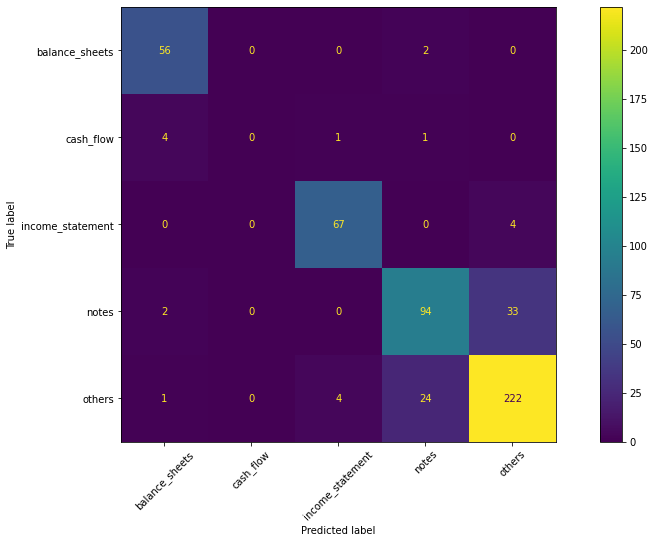

In [20]:
cm = confusion_matrix(labels, predictions, labels=DOCUMENT_CLASSES)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=DOCUMENT_CLASSES
)

cm_display.plot()
cm_display.ax_.set_xticklabels(DOCUMENT_CLASSES, rotation=45)
cm_display.figure_.set_size_inches(16, 8)

plt.show();